# Long-Short Strategy, Part 3: Evaluating our Boosting Model Signals

In this section, we'll start designing, implementing, and evaluating a trading strategy for US equities driven by daily return forecasts produced by gradient boosting models.

As in the previous examples, we'll lay out a framework and build a specific example that you can adapt to run your own experiments. There are numerous aspects that you can vary, from the asset class and investment universe to more granular aspects like the features, holding period, or trading rules. See, for example, the **Alpha Factor Library** in the [Appendix](../24_alpha_factor_library) for numerous additional features.

We'll keep the trading strategy simple and only use a single ML signal; a real-life application will likely use multiple signals from different sources, such as complementary ML models trained on different datasets or with different lookahead or lookback periods. It would also use sophisticated risk management, from simple stop-loss to value-at-risk analysis.

**Six notebooks** cover our workflow sequence:

1. [preparing_the_model_data](04_preparing_the_model_data.ipyny): we engineer a few simple features from the Quandl Wiki data 
2. [trading_signals_with_lightgbm_and_catboost](05_trading_signals_with_lightgbm_and_catboost.ipynb): we tune hyperparameters for LightGBM and CatBoost to select a model, using 2015/16 as our validation period. 
3. `evaluate_trading_signals` (this noteboook): we compare the cross-validation performance using various metrics to select the best model. 
4. [model_interpretation](07_model_interpretation.ipynb): we take a closer look at the drivers behind the best model's predictions.
5. [making_out_of_sample_predictions](08_making_out_of_sample_predictions.ipynb): we generate predictions for our out-of-sample test period 2017.
6. [backtesting_with_zipline](09_backtesting_with_zipline.ipynb): evaluate the historical performance of a long-short strategy based on our predictive signals using Zipline.

Cross-validation of numerous configurations has produced a large number of results. Now, we need to evaluate the predictive performance to identify the model that generates the most reliable and profitable signals for our prospective trading strategy.

Se toman los daily (en nuestro caso weekly) coeficientes de información, como el mejor indicador y no los totales.

## Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

from time import time
from io import StringIO
import sys, os
import warnings
from pathlib import Path
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb

from scipy.stats import spearmanr, pearsonr

from alphalens import plotting
from alphalens import performance as perf
from alphalens.utils import get_clean_factor_and_forward_returns, rate_of_return, std_conversion
from alphalens.tears import (create_summary_tear_sheet,
                             create_full_tear_sheet)

sys.path.insert(1, os.path.join(sys.path[0], '..'))
from utils import MultipleTimeSeriesCV

results_path = Path('results', 'us_stocks')

In [4]:
sns.set_style('whitegrid')

In [5]:
#YEAR = 252
#YEAR = 12
idx = pd.IndexSlice

In [6]:
scope_params = ['lookahead', 'train_length', 'test_length']
daily_ic_metrics = ['daily_ic_mean', 'daily_ic_mean_n', 'daily_ic_median', 'daily_ic_median_n']
lgb_train_params = ['learning_rate', 'num_leaves', 'feature_fraction', 'min_data_in_leaf']
rf_train_params = ['bagging_fraction', 'feature_fraction', 'min_data_in_leaf','max_depth']
catboost_train_params = ['max_depth', 'min_child_samples']

In [7]:

if not results_path.exists():
    results_path.mkdir(parents=True)

## Collect Data

We produced a larger number of LightGBM models because it runs an order of magnitude faster than CatBoost and will demonstrate some evaluation strategies accordingly.

### LightGBM

#### Summary Metrics by Fold

First, we collect the summary metrics computed for each fold and hyperparameter combination:

In [8]:
with pd.HDFStore(results_path / 'tuning_lgb.h5') as store:
    for i, key in enumerate(
        [k[1:] for k in store.keys() if k[1:].startswith('metrics')]):
        _, t, train_length, test_length = key.split('/')[:4]
        attrs = {
            'lookahead': t,
            'train_length': train_length,
            'test_length': test_length
        }
        s = store[key].to_dict()
        s.update(attrs)
        if i == 0:
            lgb_metrics = pd.Series(s).to_frame(i)
        else:
            lgb_metrics[i] = pd.Series(s)

id_vars = scope_params + lgb_train_params + daily_ic_metrics
lgb_metrics = pd.melt(lgb_metrics.T.drop('t', axis=1), 
                  id_vars=id_vars, 
                  value_name='ic', 
                  var_name='boost_rounds').dropna().apply(pd.to_numeric)

In [9]:
lgb_metrics.to_hdf('data/model_tuning.h5', 'lgb/metrics')
lgb_metrics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 702 entries, 0 to 701
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   lookahead          702 non-null    int64  
 1   train_length       702 non-null    int64  
 2   test_length        702 non-null    int64  
 3   learning_rate      702 non-null    float64
 4   num_leaves         702 non-null    float64
 5   feature_fraction   702 non-null    float64
 6   min_data_in_leaf   702 non-null    float64
 7   daily_ic_mean      702 non-null    float64
 8   daily_ic_mean_n    702 non-null    float64
 9   daily_ic_median    702 non-null    float64
 10  daily_ic_median_n  702 non-null    float64
 11  boost_rounds       702 non-null    int64  
 12  ic                 702 non-null    float64
dtypes: float64(9), int64(4)
memory usage: 71.4 KB


In [10]:
lgb_metrics.groupby(scope_params).size()

lookahead  train_length  test_length
1          464           1              702
dtype: int64

#### Information Coefficient by Day

Next, we retrieve the IC per day computed during cross-validation:

In [11]:
int_cols = ['lookahead', 'train_length', 'test_length', 'boost_rounds']

lgb_ic = []
with pd.HDFStore(results_path / 'tuning_lgb.h5') as store:
    keys = [k[1:] for k in store.keys()]
    for key in keys:
        _, t, train_length, test_length = key.split('/')[:4]
        if key.startswith('daily_ic'):
            df = (store[key]
                  .drop(['boosting', 'objective', 'verbose'], axis=1)
                 .assign(lookahead=t, 
                         train_length=train_length, 
                         test_length=test_length))
            lgb_ic.append(df)
    lgb_ic = pd.concat(lgb_ic).reset_index()


id_vars = ['date'] + scope_params + lgb_train_params
lgb_ic = pd.melt(lgb_ic, 
                 id_vars=id_vars, 
                 value_name='ic', 
                 var_name='boost_rounds').dropna()
lgb_ic.loc[:, int_cols] = lgb_ic.loc[:, int_cols].astype(int)

lgb_ic.to_hdf('data/model_tuning.h5', 'lgb/ic')
lgb_daily_ic = lgb_ic.groupby(id_vars[1:] + ['boost_rounds']).ic.mean().to_frame('ic').reset_index()
lgb_daily_ic.to_hdf('data/model_tuning.h5', 'lgb/daily_ic')

lgb_ic = pd.read_hdf('data/model_tuning.h5', 'lgb/ic')
lgb_daily_ic = pd.read_hdf('data/model_tuning.h5', 'lgb/daily_ic')

## Validation Performance: Daily vs Overall Information Coefficient

The following image shows that that LightGBM (in orange) performs (slightly) better than CatBoost, especially for longer horizons. This is not an entirely fair comparison because we ran more configurations for LightGBM, which also, unsurprisingly, shows a wider dispersion of outcomes:


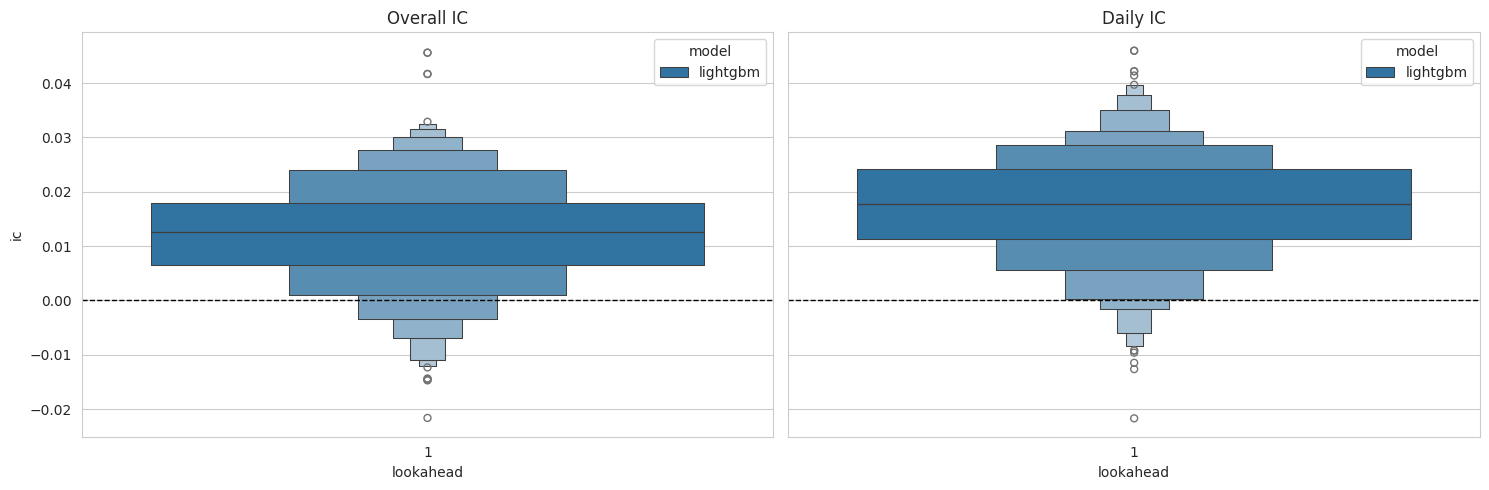

In [12]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 5), sharey=True)
sns.boxenplot(x='lookahead', y='ic', hue='model',
              data=lgb_metrics.assign(model='lightgbm'), ax=axes[0])
axes[0].axhline(0, ls='--', lw=1, c='k')
axes[0].set_title('Overall IC')
sns.boxenplot(x='lookahead', y='ic', hue='model',
              data=lgb_daily_ic.assign(model='lightgbm'), ax=axes[1])
axes[1].axhline(0, ls='--', lw=1, c='k')
axes[1].set_title('Daily IC')
fig.tight_layout()

## Cross-validation Result: Best Hyperparameters

### LightGBM

The top-performing LightGBM models use the following parameters for the three different prediction horizons.

In [13]:
group_cols = scope_params + lgb_train_params + ['boost_rounds']
lgb_daily_ic.groupby('lookahead', group_keys=False).apply(lambda x: x.nlargest(60, 'ic')).sort_values(["feature_fraction", "ic"], ascending=[True, False])

,lookahead,train_length,test_length,learning_rate,num_leaves,feature_fraction,min_data_in_leaf,boost_rounds,ic
130,1,464,1,0.01,32,0.30,250,10,0.045951
182,1,464,1,0.01,128,0.30,250,10,0.045951
131,1,464,1,0.01,32,0.30,250,25,0.042178
183,1,464,1,0.01,128,0.30,250,25,0.042178
53,1,464,1,0.01,8,0.30,250,25,0.039604
141,1,464,1,0.01,32,0.30,250,450,0.038191
193,1,464,1,0.01,128,0.30,250,450,0.038191
134,1,464,1,0.01,32,0.30,250,100,0.037860
186,1,464,1,0.01,128,0.30,250,100,0.037860
133,1,464,1,0.01,32,0.30,250,75,0.037516


In [14]:
lgb_metrics.groupby('lookahead', group_keys=False).apply(lambda x: x.nlargest(60, 'ic')).sort_values(["feature_fraction", "ic"], ascending=[True, False])
# lgb_metrics.groupby('lookahead', group_keys=False).apply(lambda x: x.nlargest(3, 'ic')).to_csv('results/best_lgb_model.csv', index=False)

,lookahead,train_length,test_length,learning_rate,num_leaves,feature_fraction,min_data_in_leaf,daily_ic_mean,daily_ic_mean_n,daily_ic_median,daily_ic_median_n,boost_rounds,ic
45,1,464,1,0.01,32.0,0.3,250.0,0.045951,10.0,0.045455,10.0,10,0.045591
52,1,464,1,0.01,128.0,0.3,250.0,0.045951,10.0,0.045455,10.0,10,0.045591
99,1,464,1,0.01,32.0,0.3,250.0,0.045951,10.0,0.045455,10.0,25,0.041675
106,1,464,1,0.01,128.0,0.3,250.0,0.045951,10.0,0.045455,10.0,25,0.041675
631,1,464,1,0.01,8.0,0.3,250.0,0.039604,25.0,0.031818,25.0,450,0.032882
207,1,464,1,0.01,32.0,0.3,250.0,0.045951,10.0,0.045455,10.0,75,0.032547
214,1,464,1,0.01,128.0,0.3,250.0,0.045951,10.0,0.045455,10.0,75,0.032547
261,1,464,1,0.01,32.0,0.3,250.0,0.045951,10.0,0.045455,10.0,100,0.032431
268,1,464,1,0.01,128.0,0.3,250.0,0.045951,10.0,0.045455,10.0,100,0.032431
37,1,464,1,0.01,8.0,0.3,250.0,0.039604,25.0,0.031818,25.0,10,0.032333


In [15]:
lgb_metrics.groupby('lookahead', group_keys=False).apply(lambda x: x.nlargest(10, 'daily_ic_mean'))

,lookahead,train_length,test_length,learning_rate,num_leaves,feature_fraction,min_data_in_leaf,daily_ic_mean,daily_ic_mean_n,daily_ic_median,daily_ic_median_n,boost_rounds,ic
45,1,464,1,0.01,32.0,0.3,250.0,0.045951,10.0,0.045455,10.0,10,0.045591
52,1,464,1,0.01,128.0,0.3,250.0,0.045951,10.0,0.045455,10.0,10,0.045591
99,1,464,1,0.01,32.0,0.3,250.0,0.045951,10.0,0.045455,10.0,25,0.041675
106,1,464,1,0.01,128.0,0.3,250.0,0.045951,10.0,0.045455,10.0,25,0.041675
153,1,464,1,0.01,32.0,0.3,250.0,0.045951,10.0,0.045455,10.0,50,0.030874
160,1,464,1,0.01,128.0,0.3,250.0,0.045951,10.0,0.045455,10.0,50,0.030874
207,1,464,1,0.01,32.0,0.3,250.0,0.045951,10.0,0.045455,10.0,75,0.032547
214,1,464,1,0.01,128.0,0.3,250.0,0.045951,10.0,0.045455,10.0,75,0.032547
261,1,464,1,0.01,32.0,0.3,250.0,0.045951,10.0,0.045455,10.0,100,0.032431
268,1,464,1,0.01,128.0,0.3,250.0,0.045951,10.0,0.045455,10.0,100,0.032431


### Visualization

#### LightGBM

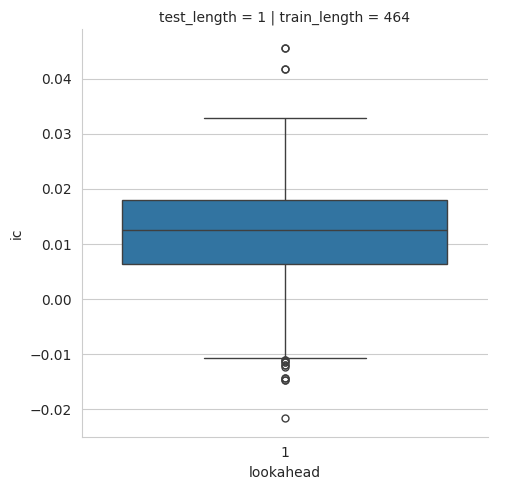

In [16]:
g = sns.catplot(x='lookahead', y='ic',
                col='train_length', row='test_length',
                data=lgb_metrics,
                kind='box')

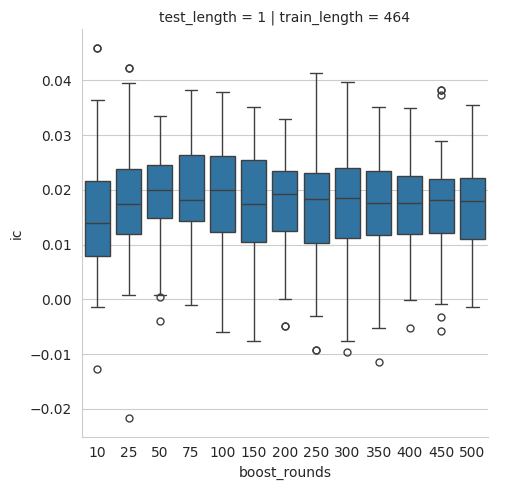

In [17]:
t=1
g=sns.catplot(x='boost_rounds',
            y='ic',
            col='train_length',
            row='test_length',
            data=lgb_daily_ic[lgb_daily_ic.lookahead == t],
            kind='box')

## AlphaLens Analysis - Validation Performance

### LightGBM

#### Select Parameters

In [18]:
lgb_daily_ic = pd.read_hdf('data/model_tuning.h5', 'lgb/daily_ic')
lgb_daily_ic.info()

<class 'pandas.core.frame.DataFrame'>
Index: 702 entries, 0 to 701
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   lookahead         702 non-null    int64  
 1   train_length      702 non-null    int64  
 2   test_length       702 non-null    int64  
 3   learning_rate     702 non-null    float64
 4   num_leaves        702 non-null    int64  
 5   feature_fraction  702 non-null    float64
 6   min_data_in_leaf  702 non-null    int64  
 7   boost_rounds      702 non-null    int64  
 8   ic                702 non-null    float64
dtypes: float64(3), int64(6)
memory usage: 54.8 KB


In [19]:
def get_lgb_params(data, t=5, best=0):
    param_cols = scope_params[1:] + lgb_train_params + ['boost_rounds']
    df = data[data.lookahead==t].sort_values('ic', ascending=False).iloc[best]
    return df.loc[param_cols]

In [20]:
def get_lgb_key(t, p):
    key = f'{t}/{int(p.train_length)}/{int(p.test_length)}/{p.learning_rate}/'
    return key + f'{int(p.num_leaves)}/{p.feature_fraction}/{int(p.min_data_in_leaf)}'

In [21]:
best_params = get_lgb_params(lgb_daily_ic, t=1, best=0)
best_params

train_length        464.00
test_length           1.00
learning_rate         0.01
num_leaves          128.00
feature_fraction      0.30
min_data_in_leaf    250.00
boost_rounds         10.00
Name: 182, dtype: float64

In [22]:
best_params.to_hdf('data.h5', 'best_params')

#### Plot rolling IC

In [23]:
def select_ic(params, ic_data, lookahead):
    return ic_data.loc[(ic_data.lookahead == lookahead) &
                       (ic_data.train_length == params.train_length) &
                       (ic_data.test_length == params.test_length) &
                       (ic_data.learning_rate == params.learning_rate) &
                       (ic_data.num_leaves == params.num_leaves) &
                       (ic_data.feature_fraction == params.feature_fraction) &
                       (ic_data.boost_rounds == params.boost_rounds), ['date', 'ic']].set_index('date')

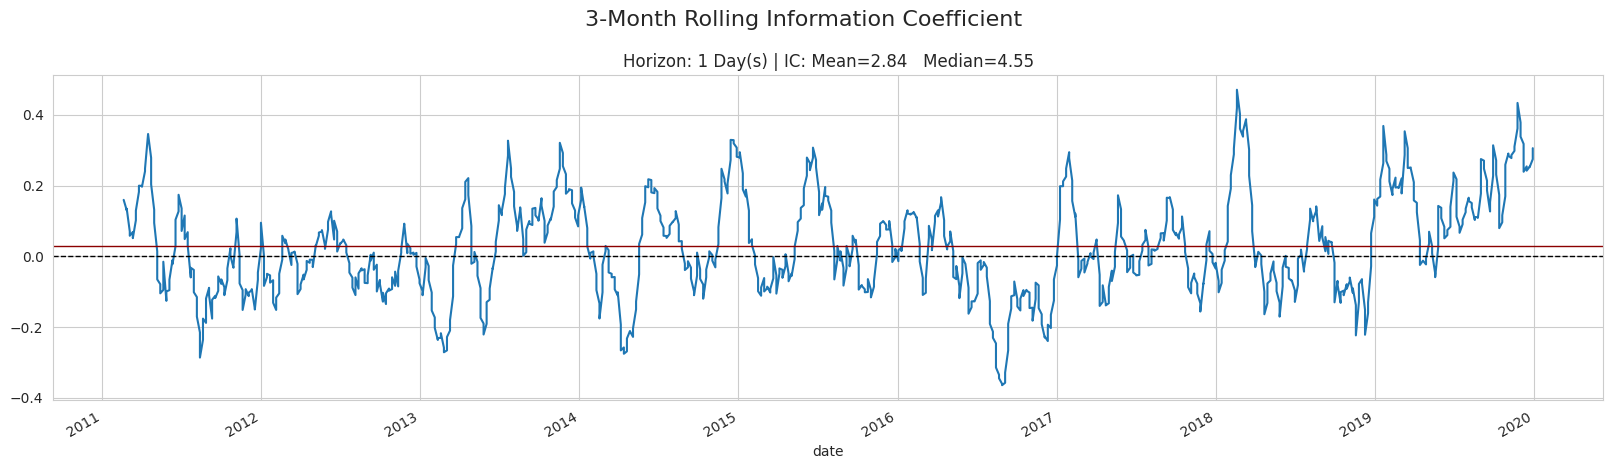

In [24]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 5))
# axes = axes.flatten()


for i, t in enumerate([1]): #modificado para meses un lookahead
    params = get_lgb_params(lgb_daily_ic, t=t)
    data = select_ic(params, lgb_ic, lookahead=t).sort_index()
    #rolling = data.rolling(63).ic.mean().dropna()
    rolling = data.rolling(3*4).ic.mean().dropna()#semanas
    avg = data.ic.mean()
    med = data.ic.median()
    rolling.plot(ax=axes, title=f'Horizon: {t} Day(s) | IC: Mean={avg*100:.2f}   Median={med*100:.2f}')
    axes.axhline(avg, c='darkred', lw=1)
    axes.axhline(0, ls='--', c='k', lw=1)

fig.suptitle('3-Month Rolling Information Coefficient', fontsize=16)
# fig.tight_layout()
fig.subplots_adjust(top=0.85);

#### Get Predictions for Validation Period

We retrieve the predictions for the 10 validation runs:

In [25]:
lookahead = 1
topn = 10
for best in range(topn):
    best_params = get_lgb_params(lgb_daily_ic, t=lookahead, best=best)
    key = get_lgb_key(lookahead, best_params)
    rounds = str(int(best_params.boost_rounds))
    if best == 0:
        best_predictions = pd.read_hdf(results_path / 'tuning_lgb.h5', 'predictions/' + key)
        best_predictions = best_predictions[rounds].to_frame(best)
    else:
        best_predictions[best] = pd.read_hdf(results_path / 'tuning_lgb.h5',
                                             'predictions/' + key)[rounds]
best_predictions = best_predictions.sort_index()

In [26]:
best_predictions.to_hdf('data/predictions.h5', f'lgb/train/{lookahead:02}')
best_predictions.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5148 entries, ('IYR', Timestamp('2011-01-16 00:00:00')) to ('XLY', Timestamp('2019-12-29 00:00:00'))
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       5148 non-null   float64
 1   1       5148 non-null   float64
 2   2       5148 non-null   float64
 3   3       5148 non-null   float64
 4   4       5148 non-null   float64
 5   5       5148 non-null   float64
 6   6       5148 non-null   float64
 7   7       5148 non-null   float64
 8   8       5148 non-null   float64
 9   9       5148 non-null   float64
dtypes: float64(10)
memory usage: 460.2+ KB


#### Get Trade Prices

Using next available prices. !! Esta parte del código no está revisada para una adaptacion mensual, no tomar como buena para conclusiones

In [27]:
#modificado
def get_trade_prices(tickers):
    idx = pd.IndexSlice
    DATA_STORE = 'data/assets.h5'
    with pd.HDFStore(DATA_STORE) as store:
        prices = (store['data_close'])  
    display(prices)
    return (prices.loc[idx[tickers, '2012': '2024'], 'open']
            .unstack('ticker')
            .sort_index()
            .shift(-1)
            .tz_localize('UTC')
            .resample('W').last())

In [28]:
test_tickers = best_predictions.index.get_level_values('ticker').unique()#modificado

In [29]:
trade_prices = get_trade_prices(test_tickers)
trade_prices.info()

open        high         low       close     volume  \
ticker date                                                                    
IYR    2000-01-03   19.267872   19.267872   18.455524   18.582453  1185699.0   
       2000-01-04   18.176279   18.201666   17.605097   17.770105   885705.0   
       2000-01-05   17.770105   17.960501   17.440088   17.630484   717181.0   
       2000-01-06   17.681255   18.518990   17.681255   18.404753   415832.0   
       2000-01-07   18.531681   18.734768   18.277822   18.709383   468149.0   
...                       ...         ...         ...         ...        ...   
XLY    2024-12-18  237.529999  240.279999  227.710007  228.639999  7202500.0   
       2024-12-19  231.759995  232.419998  226.970001  228.330002  6602600.0   
       2024-12-20  226.039993  232.509995  225.500000  228.910004  5457900.0   
       2024-12-23  228.889999  229.399994  226.179993  229.169998  2961200.0   
       2024-12-24  230.139999  234.500000  229.949997  234.470001  1276300.0   

                    Adj Close  
ticker date                    
IYR    2000-01-03   11.303076  
       2000-01-04   10.808953  
       2000-01-05   10.724020  
       2000-01-06   11.194989  
       2000-01-07   11.380283  
...                       ...  
XLY    2024-12-18  228.207520  
       2024-12-19  227.898102  
       2024-12-20  228.477005  
       2024-12-23  229.169998  
       2024-12-24  234.470001  

[69135 rows x 6 columns]

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 678 entries, 2012-01-08 00:00:00+00:00 to 2024-12-29 00:00:00+00:00
Freq: W-SUN
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   IYR     678 non-null    float64
 1   VOX     678 non-null    float64
 2   XLB     678 non-null    float64
 3   XLE     678 non-null    float64
 4   XLF     678 non-null    float64
 5   XLI     678 non-null    float64
 6   XLK     678 non-null    float64
 7   XLP     678 non-null    float64
 8   XLU     678 non-null    float64
 9   XLV     678 non-null    float64
 10  XLY     678 non-null    float64
dtypes: float64(11)
memory usage: 63.6 KB


In [30]:
# persist result in case we want to rerun:
trade_prices.to_hdf('data/model_tuning.h5', 'trade_prices/model_selection')
trade_prices = pd.read_hdf('data/model_tuning.h5', 'trade_prices/model_selection')

In [31]:
trade_prices.tail()

ticker,IYR,VOX,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY
date,,,,,,,,,,,
2024-12-01 00:00:00+00:00,101.849998,155.529999,94.879997,95.500000,51.419998,143.899994,233.899994,83.139999,82.919998,147.320007,223.869995
2024-12-08 00:00:00+00:00,99.820000,161.000000,92.639999,91.779999,50.439999,140.589996,239.940002,82.500000,79.690002,144.419998,234.139999
2024-12-15 00:00:00+00:00,97.750000,162.580002,89.050003,88.970001,49.570000,137.580002,239.360001,82.070000,77.709999,140.880005,236.710007
2024-12-22 00:00:00+00:00,92.209999,156.960007,85.029999,83.309998,48.060001,132.990005,236.250000,79.050003,75.610001,137.600006,228.889999
2024-12-29 00:00:00+00:00,92.540001,157.919998,85.089996,84.169998,48.520000,132.979996,238.919998,78.849998,76.059998,138.630005,230.139999


We average the top five models and provide the corresponding prices to Alphalens, in order to compute the mean period-wise return earned on an equal-weighted portfolio invested in the daily factor quintiles for various holding periods:

In [32]:
factor = best_predictions.iloc[:, :5].mean(1).dropna().tz_localize('UTC', level='date').swaplevel()

In [33]:
factor.tail()

date                       ticker
2019-12-01 00:00:00+00:00  XLY       0.067619
2019-12-08 00:00:00+00:00  XLY       0.044539
2019-12-15 00:00:00+00:00  XLY      -0.012103
2019-12-22 00:00:00+00:00  XLY       0.033723
2019-12-29 00:00:00+00:00  XLY      -0.004414
dtype: float64

In [34]:
trade_prices.tail()

ticker,IYR,VOX,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY
date,,,,,,,,,,,
2024-12-01 00:00:00+00:00,101.849998,155.529999,94.879997,95.500000,51.419998,143.899994,233.899994,83.139999,82.919998,147.320007,223.869995
2024-12-08 00:00:00+00:00,99.820000,161.000000,92.639999,91.779999,50.439999,140.589996,239.940002,82.500000,79.690002,144.419998,234.139999
2024-12-15 00:00:00+00:00,97.750000,162.580002,89.050003,88.970001,49.570000,137.580002,239.360001,82.070000,77.709999,140.880005,236.710007
2024-12-22 00:00:00+00:00,92.209999,156.960007,85.029999,83.309998,48.060001,132.990005,236.250000,79.050003,75.610001,137.600006,228.889999
2024-12-29 00:00:00+00:00,92.540001,157.919998,85.089996,84.169998,48.520000,132.979996,238.919998,78.849998,76.059998,138.630005,230.139999


In [35]:
freq = pd.infer_freq(trade_prices.index)
print(freq)

W-SUN


#### Create AlphaLens Inputs

In [36]:
factor_data = get_clean_factor_and_forward_returns(factor=factor,
                                                   prices=trade_prices,
                                                   quantiles=5,
                                                   #periods=(1, 2))#modificado
                                                   periods=(1,2),max_loss=2)#modificado

Dropped 10.9% entries from factor data: 10.9% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 200.0%, not exceeded: OK!


In [37]:
factor_data

,,1D,2D,factor,factor_quantile
date,asset,,,,
2012-01-08 00:00:00+00:00,IYR,0.022659,0.038468,0.007873,4
2012-01-15 00:00:00+00:00,IYR,0.015459,0.035039,0.059632,5
2012-01-22 00:00:00+00:00,IYR,0.019283,0.046685,0.086301,5
2012-01-29 00:00:00+00:00,IYR,0.026884,0.016927,0.036517,4
2012-02-05 00:00:00+00:00,IYR,-0.009696,-0.010343,0.044696,4
...,...,...,...,...,...
2019-12-01 00:00:00+00:00,XLY,-0.007263,0.010364,0.067619,5
2019-12-08 00:00:00+00:00,XLY,0.017756,0.026058,0.044539,5
2019-12-15 00:00:00+00:00,XLY,0.008158,0.018981,-0.012103,1


#### Compute Alphalens metrics

In [38]:
mean_quant_ret_bydate, std_quant_daily = perf.mean_return_by_quantile(
    factor_data,
    by_date=True,
    by_group=False,
    demeaned=True,
    group_adjust=False,
)

In [39]:
factor_returns = perf.factor_returns(factor_data)

In [40]:
mean_quant_ret, std_quantile = perf.mean_return_by_quantile(factor_data,
                                                            by_group=False,
                                                            demeaned=True)



mean_quant_rateret = mean_quant_ret.apply(rate_of_return, axis=0,
                                          base_period=mean_quant_ret.columns[0])

In [41]:
import numpy as np

# Reemplazar infinitos con la media de cada columna numérica
numeric_cols = factor_data.select_dtypes(include=np.number).columns
for col in numeric_cols:
    mask = np.isinf(factor_data[col])
    factor_data.loc[mask, col] = factor_data[col].replace([np.inf, -np.inf], np.nan).mean()

print("Number of NaN values in factor_data:")
print(factor_data.isna().sum())
print("\nTotal NaN values:", factor_data.isna().sum().sum())
print("\nNumber of infinite values:", np.isinf(factor_data.select_dtypes(include=np.number)).sum().sum())
print("\nShape of factor_data:", factor_data.shape)
print("\nSample of factor_data:")
factor_data

Number of NaN values in factor_data:
1D                 0
2D                 0
factor             0
factor_quantile    0
dtype: int64

Total NaN values: 0

Number of infinite values: 0

Shape of factor_data: (4587, 4)

Sample of factor_data:


,,1D,2D,factor,factor_quantile
date,asset,,,,
2012-01-08 00:00:00+00:00,IYR,0.022659,0.038468,0.007873,4.0
2012-01-15 00:00:00+00:00,IYR,0.015459,0.035039,0.059632,5.0
2012-01-22 00:00:00+00:00,IYR,0.019283,0.046685,0.086301,5.0
2012-01-29 00:00:00+00:00,IYR,0.026884,0.016927,0.036517,4.0
2012-02-05 00:00:00+00:00,IYR,-0.009696,-0.010343,0.044696,4.0
...,...,...,...,...,...
2019-12-01 00:00:00+00:00,XLY,-0.007263,0.010364,0.067619,5.0
2019-12-08 00:00:00+00:00,XLY,0.017756,0.026058,0.044539,5.0
2019-12-15 00:00:00+00:00,XLY,0.008158,0.018981,-0.012103,1.0


In [42]:
mean_quant_ret_bydate, std_quant_daily = perf.mean_return_by_quantile(
    factor_data,
    by_date=True,
    by_group=False,
    demeaned=True,
    group_adjust=False,
)

mean_quant_rateret_bydate = mean_quant_ret_bydate.apply(
    rate_of_return,
    base_period=mean_quant_ret_bydate.columns[0],
)

compstd_quant_daily = std_quant_daily.apply(std_conversion,
                                            base_period=std_quant_daily.columns[0])

alpha_beta = perf.factor_alpha_beta(factor_data,
                                    demeaned=True)

mean_ret_spread_quant, std_spread_quant = perf.compute_mean_returns_spread(
    mean_quant_rateret_bydate,
    factor_data["factor_quantile"].max(),
    factor_data["factor_quantile"].min(),
    std_err=compstd_quant_daily,
)

In [43]:
mean_ret_spread_quant.mean().mul(10000).to_frame('Mean Period Wise Spread (bps)').join(alpha_beta.T).T

,1D,2D
Mean Period Wise Spread (bps),8.686264,5.441407
Ann. alpha,0.111194,0.057337
beta,0.042778,0.013078


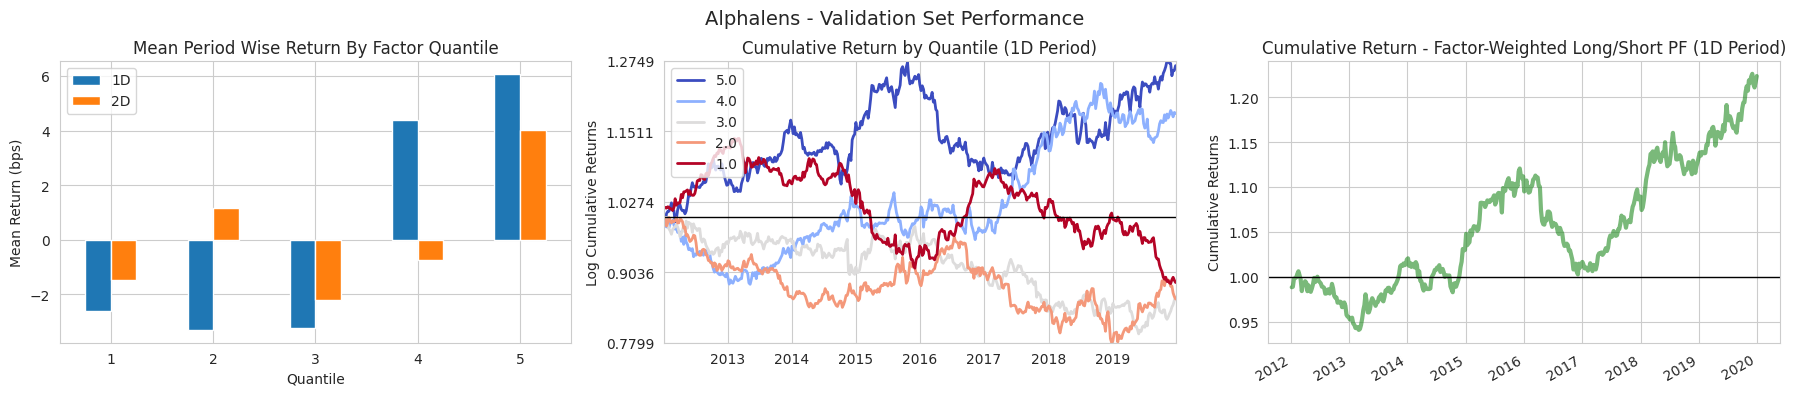

In [44]:
fig, axes = plt.subplots(ncols=3, figsize=(18, 4))


plotting.plot_quantile_returns_bar(mean_quant_rateret, ax=axes[0])
plt.setp(axes[0].xaxis.get_majorticklabels(), rotation=0)
axes[0].set_xlabel('Quantile')

plotting.plot_cumulative_returns_by_quantile(mean_quant_ret_bydate['1D'],
                                             freq=pd.tseries.offsets.BDay(),
                                             period='1D',
                                             ax=axes[1])
axes[1].set_title('Cumulative Return by Quantile (1D Period)')

title = "Cumulative Return - Factor-Weighted Long/Short PF (1D Period)"
plotting.plot_cumulative_returns(factor_returns['1D'],
                                 period='1D',
                                 freq=pd.tseries.offsets.BDay(),
                                 title=title,
                                 ax=axes[2])

fig.suptitle('Alphalens - Validation Set Performance', fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=.85);

#### Summary Tearsheet

Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1.0,-0.175739,0.007724,-0.049089,0.025630,1251,27.272727
2.0,-0.074075,0.031805,-0.014677,0.017352,834,18.181818
3.0,-0.055853,0.051484,0.005620,0.015937,834,18.181818
4.0,-0.029452,0.084859,0.026098,0.016812,834,18.181818
5.0,-0.005318,0.149851,0.055430,0.023368,834,18.181818


Returns Analysis


,1D,2D
Ann. alpha,0.111,0.057
beta,0.043,0.013
Mean Period Wise Return Top Quantile (bps),6.077,4.017
Mean Period Wise Return Bottom Quantile (bps),-2.609,-1.482
Mean Period Wise Spread (bps),8.686,5.441


Information Analysis


,1D,2D
IC Mean,0.045,0.017
IC Std.,0.360,0.356
Risk-Adjusted IC,0.125,0.049
t-stat(IC),2.559,1.004
p-value(IC),0.011,0.316
IC Skew,-0.101,0.000
IC Kurtosis,-0.458,-0.410


Turnover Analysis


,1D,2D
Quantile 1 Mean Turnover,0.617,0.598
Quantile 2 Mean Turnover,0.793,0.807
Quantile 3 Mean Turnover,0.809,0.822
Quantile 4 Mean Turnover,0.819,0.817
Quantile 5 Mean Turnover,0.709,0.713


,1D,2D
Mean Factor Rank Autocorrelation,0.231,0.24


<Figure size 640x480 with 0 Axes>

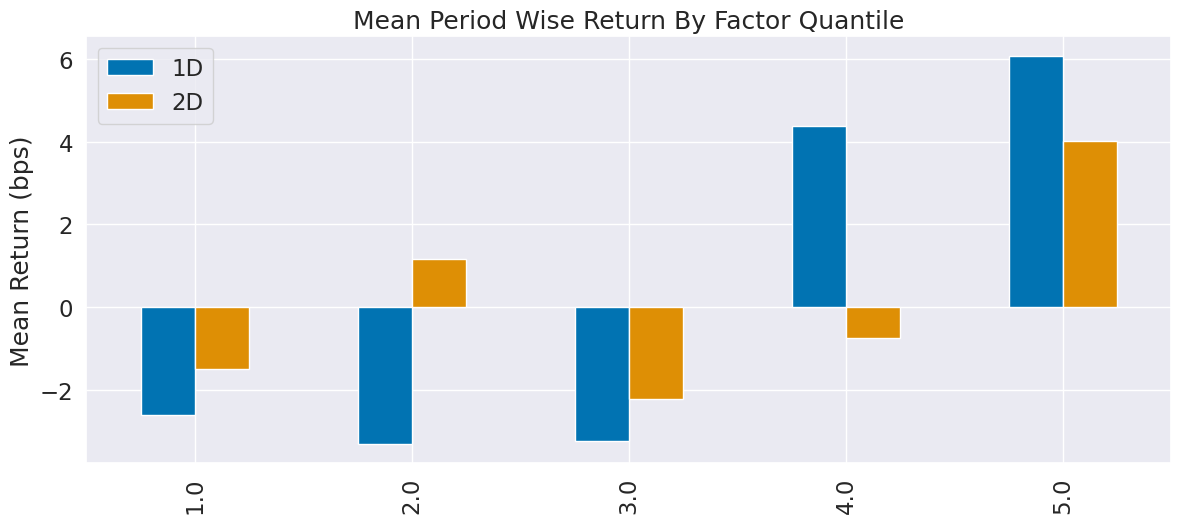

In [45]:
create_summary_tear_sheet(factor_data)

Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1.0,-0.175739,0.007724,-0.049089,0.025630,1251,27.272727
2.0,-0.074075,0.031805,-0.014677,0.017352,834,18.181818
3.0,-0.055853,0.051484,0.005620,0.015937,834,18.181818
4.0,-0.029452,0.084859,0.026098,0.016812,834,18.181818
5.0,-0.005318,0.149851,0.055430,0.023368,834,18.181818


Returns Analysis


,1D,2D
Ann. alpha,0.111,0.057
beta,0.043,0.013
Mean Period Wise Return Top Quantile (bps),6.077,4.017
Mean Period Wise Return Bottom Quantile (bps),-2.609,-1.482
Mean Period Wise Spread (bps),8.686,5.441


<Figure size 640x480 with 0 Axes>

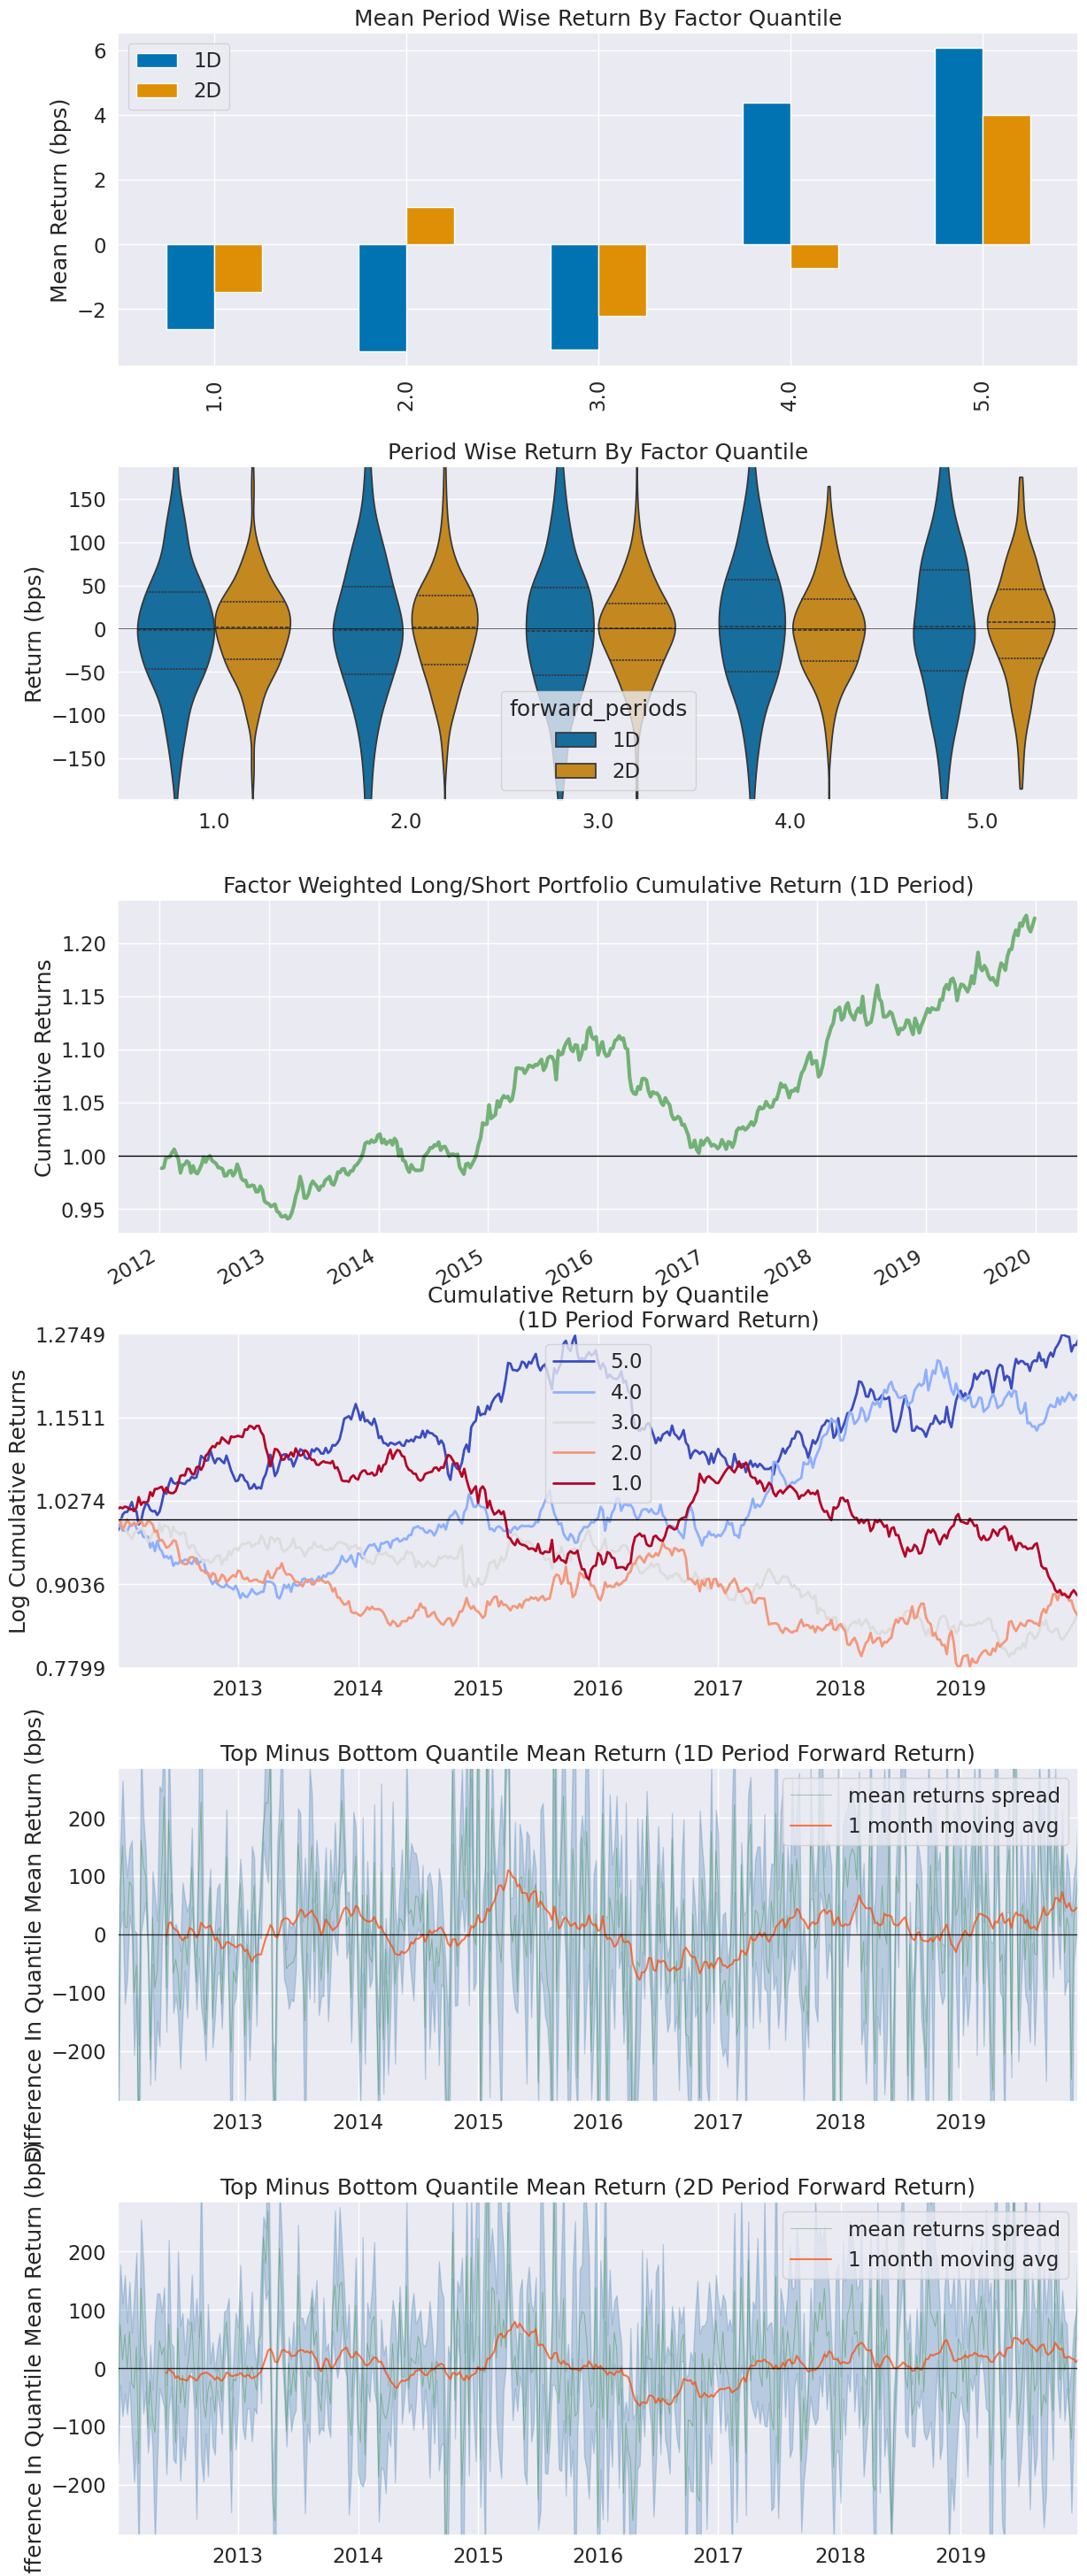

Information Analysis


,1D,2D
IC Mean,0.045,0.017
IC Std.,0.360,0.356
Risk-Adjusted IC,0.125,0.049
t-stat(IC),2.559,1.004
p-value(IC),0.011,0.316
IC Skew,-0.101,0.000
IC Kurtosis,-0.458,-0.410


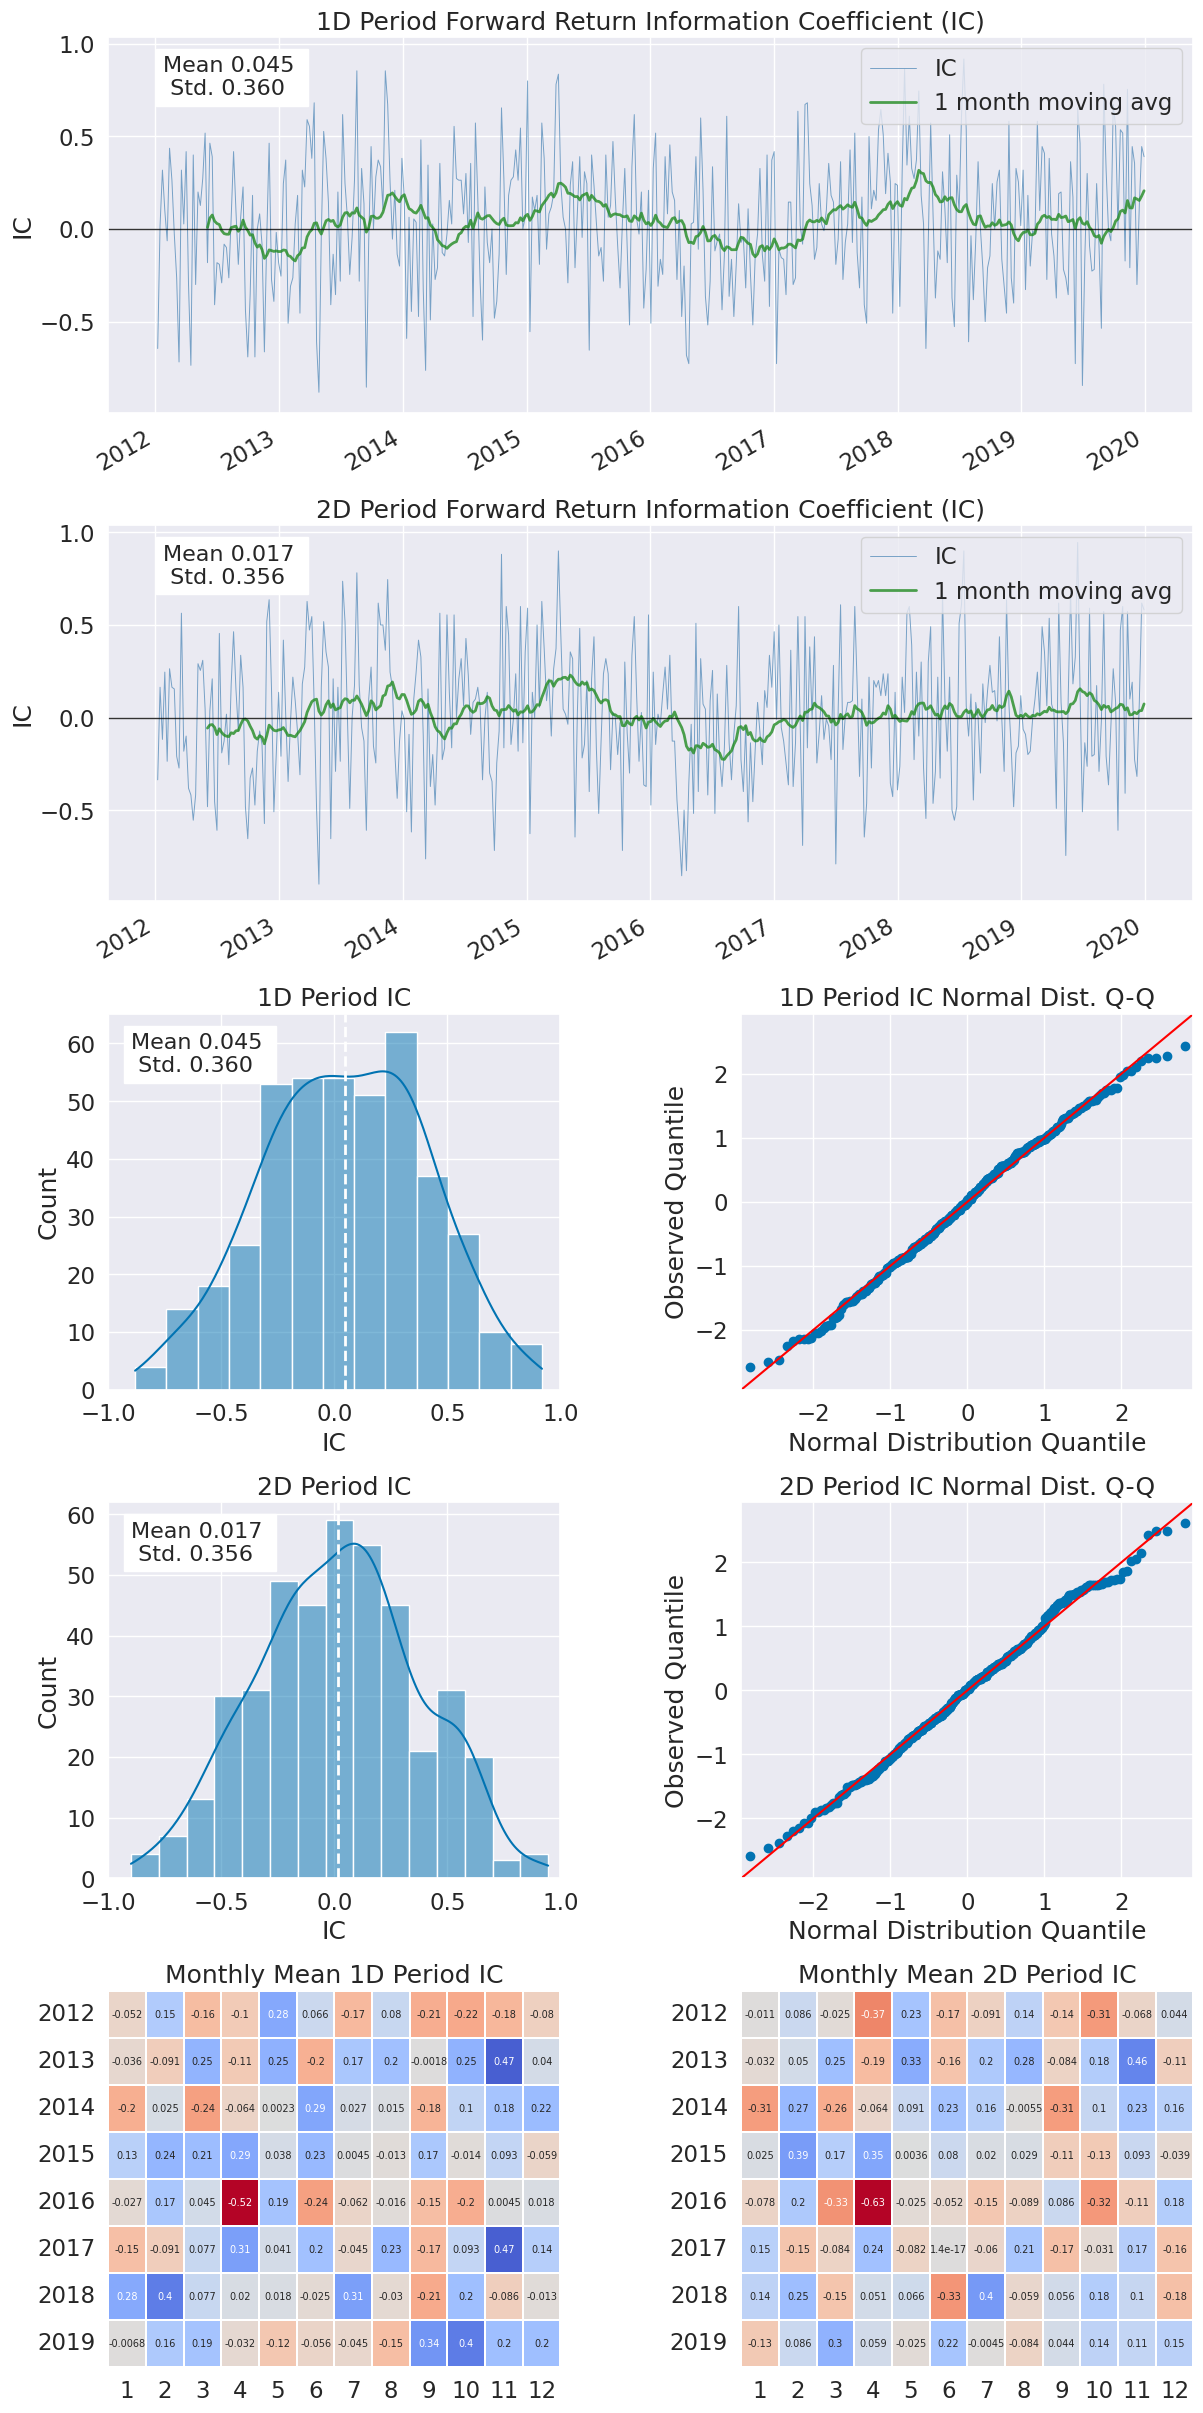

Turnover Analysis


,1D,2D
Quantile 1.0 Mean Turnover,0.617,0.598
Quantile 2.0 Mean Turnover,0.793,0.807
Quantile 3.0 Mean Turnover,0.809,0.822
Quantile 4.0 Mean Turnover,0.819,0.817
Quantile 5.0 Mean Turnover,0.709,0.713


,1D,2D
Mean Factor Rank Autocorrelation,0.231,0.24


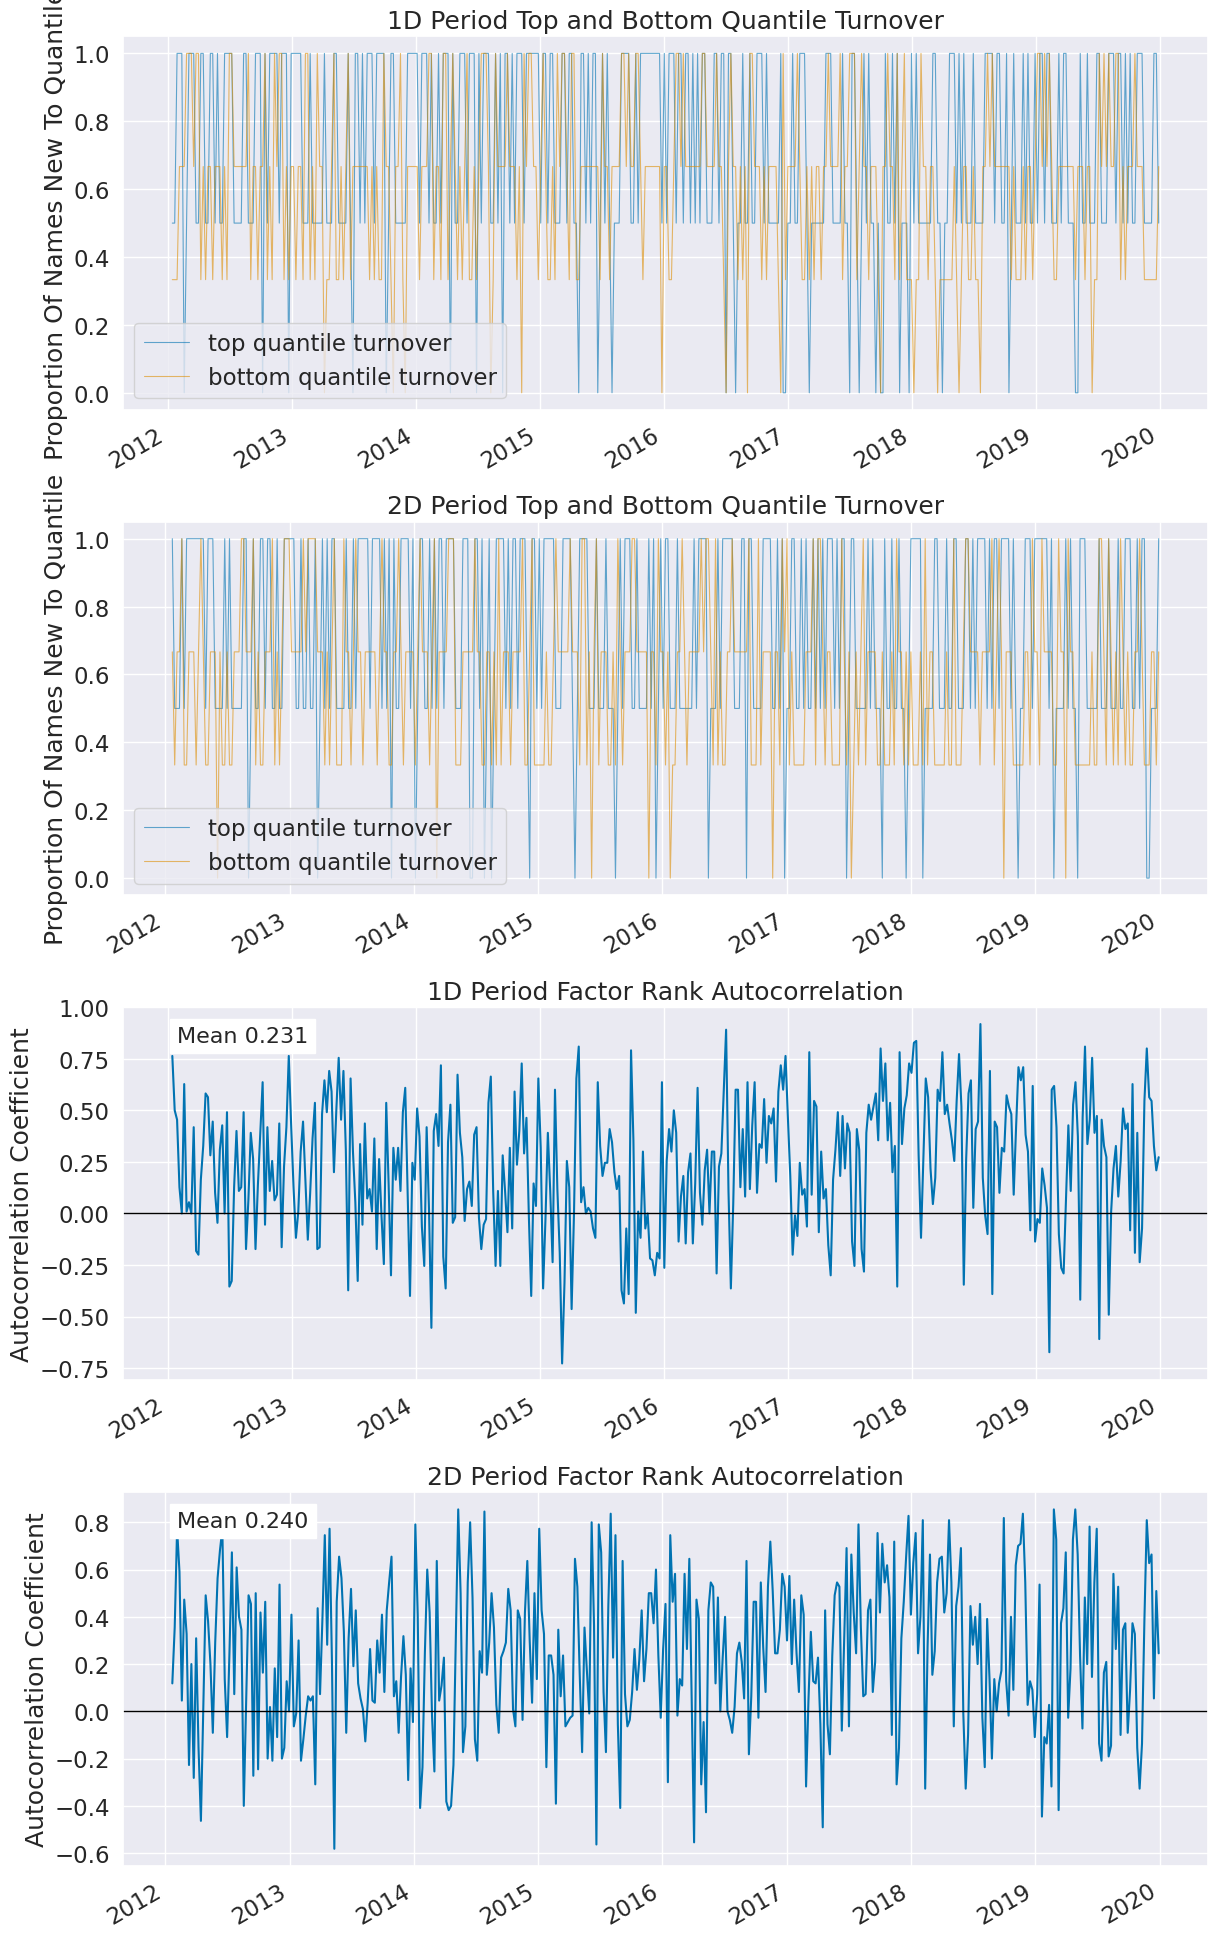

In [46]:
create_full_tear_sheet(factor_data)